# Imports

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [21]:
!pip install googleimagedownloader
from googleimagedownloader.googleimagedownloader import GoogleImageDownloader

# Transfer Learning

## Build the dataset

In [0]:
class_names = ['messi','cristiano_ronaldo']
path = 'dataset/'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_messi_dir = os.path.join(train_dir, 'messi')  
train_cr_dir = os.path.join(train_dir, 'cristiano_ronaldo')  
validation_messi_dir = os.path.join(validation_dir, 'messi') 
validation_cr_dir = os.path.join(validation_dir, 'cristiano_ronaldo')  

if os.path.exists(path):
  shutil.rmtree(path)

os.makedirs(train_messi_dir)
os.makedirs(train_cr_dir)
os.makedirs(validation_messi_dir)    
os.makedirs(validation_cr_dir)

In [0]:
def manage_images(src, dest_train, dest_val, image_resize=(224,224), val_split=0.1, prefix=''):
  total = len(os.listdir(src))
  val = np.int(total*val_split)
  count = 0
  files = os.listdir(src)

  for file_name in files:
    try:
      dest = dest_train if count >= val else dest_val
      dest_file = os.path.join(dest, prefix + file_name) 

      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #resize
      img = img.resize(image_resize, Image.ANTIALIAS)
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return


In [0]:
img_dir = os.path.realpath('Images/')

In [51]:
queries = ['Messi']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='messi '+query, numberImage=200)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_messi_dir, validation_messi_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=messi Messi&source=lnms&tbm=isch
Number of Images cannot exceeds 100
Error  'NoneType' object is not iterable
Invalid image:  45.jpg cannot identify image file '/content/Images/45.jpg'
Invalid image:  88.jpg cannot identify image file '/content/Images/88.jpg'
Invalid image:  46.jpg cannot identify image file '/content/Images/46.jpg'
Invalid image:  92.jpg cannot identify image file '/content/Images/92.jpg'
Invalid image:  74.jpg cannot write mode RGBA as JPEG
Invalid image:  24.jpg cannot identify image file '/content/Images/24.jpg'
Invalid image:  47.jpg cannot identify image file '/content/Images/47.jpg'
Invalid image:  95.jpg cannot write mode RGBA as JPEG
Invalid image:  71.jpg cannot identify image file '/content/Images/71.jpg'
Invalid image:  38.jpg cannot identify image file '/content/Images/38.jpg'
Invalid image:  12.jpg cannot identify image file '/content/Images/12.jpg'
Invalid image:  0.jpg cannot identify image file '/content/Images/0.jpg'


In [52]:
queries = ['cristiano ronaldo']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='cristiano ronaldo '+query, numberImage=200)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_cr_dir, validation_cr_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=cristiano ronaldo cristiano ronaldo&source=lnms&tbm=isch
Number of Images cannot exceeds 100
Error  'NoneType' object is not iterable
Invalid image:  45.jpg cannot identify image file '/content/Images/45.jpg'
Invalid image:  88.jpg cannot identify image file '/content/Images/88.jpg'
Invalid image:  46.jpg cannot identify image file '/content/Images/46.jpg'
Invalid image:  92.jpg cannot identify image file '/content/Images/92.jpg'
Invalid image:  74.jpg cannot write mode RGBA as JPEG
Invalid image:  24.jpg cannot identify image file '/content/Images/24.jpg'
Invalid image:  47.jpg cannot identify image file '/content/Images/47.jpg'
Invalid image:  95.jpg cannot write mode RGBA as JPEG
Invalid image:  71.jpg cannot identify image file '/content/Images/71.jpg'
Invalid image:  38.jpg cannot identify image file '/content/Images/38.jpg'
Invalid image:  12.jpg cannot identify image file '/content/Images/12.jpg'
Invalid image:  0.jpg cannot identify image file 

In [54]:
total_train = len(os.listdir(train_messi_dir))+ len(os.listdir(train_cr_dir))
total_val = len(os.listdir(validation_messi_dir))+ len(os.listdir(validation_cr_dir))

print('total training messi images:', len(os.listdir(train_messi_dir)))
print('total training cristiano ronaldo images:', len(os.listdir(train_cr_dir)))

print('total validation messi images:', len(os.listdir(validation_messi_dir)))
print('total validation cristiano ronaldo images:', len(os.listdir(validation_cr_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training messi images: 77
total training cristiano ronaldo images: 77
total validation messi images: 10
total validation cristiano ronaldo images: 10
--
Total training images: 154
Total validation images: 20


## Using the dataset

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [56]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=(224, 224),
                                                           class_mode='binary')

Found 154 images belonging to 2 classes.


In [57]:
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=(224, 224),
                                                              class_mode='binary')

Found 20 images belonging to 2 classes.


## Testing the classifier

In [0]:
image_batch, labels_batch = next(train_data_gen)

In [59]:
IMAGE_SIZE = (224, 224)
classifier_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4" 
classifier = Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SIZE+(3,))
])
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [61]:
labels_path = get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['scoreboard', 'bib', 'shield', 'torch', 'puck', 'ballplayer',
       'basketball', 'lab coat', 'torch', 'rugby ball', 'torch',
       'ballplayer', 'swimming trunks', 'basketball', 'ballplayer',
       'comic book', 'bearskin', 'ballplayer', 'soccer ball', 'crutch',
       'rugby ball', 'torch', 'ballplayer', 'basketball', 'torch',
       'prison', 'basketball', 'rugby ball', 'ballplayer', 'soccer ball',
       'bubble', 'torch'], dtype='<U30')

In [0]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

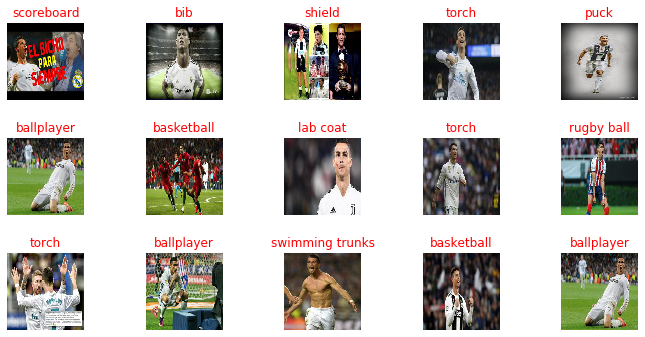

In [63]:
plot_images(image_batch, labels_batch, predicted_class_names)

## Downloading headless model

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SIZE+(3,))

In [66]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [0]:
feature_extractor_layer.trainable = False

## Adding a classification head

In [68]:
model = Sequential([
  feature_extractor_layer,
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


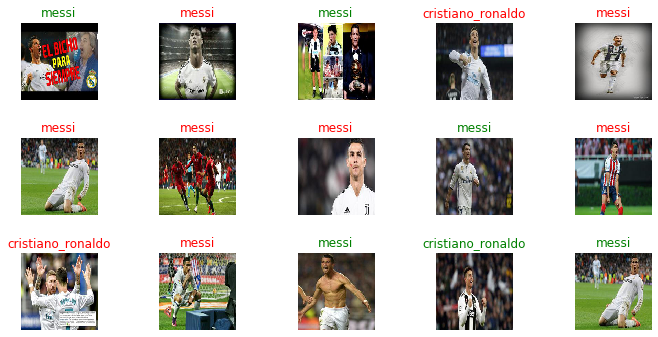

In [69]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Train the model

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 1 steps
Epoch 1/5
5/5 [==============================] - 20s 4s/step - loss: 1.7919 - accuracy: 0.4286 - val_loss: 1.5331 - val_accuracy: 0.5000
Epoch 2/5
5/5 [==============================] - 17s 3s/step - loss: 1.5655 - accuracy: 0.4610 - val_loss: 0.8449 - val_accuracy: 0.5000
Epoch 3/5
5/5 [==============================] - 17s 3s/step - loss: 1.4332 - accuracy: 0.4481 - val_loss: 0.7430 - val_accuracy: 0.5000
Epoch 4/5
5/5 [==============================] - 17s 3s/step - loss: 1.2780 - accuracy: 0.4610 - val_loss: 0.9071 - val_accuracy: 0.5000
Epoch 5/5
5/5 [==============================] - 17s 3s/step - loss: 0.8322 - accuracy: 0.5390 - val_loss: 0.9050 - val_accuracy: 0.5000


## Check results

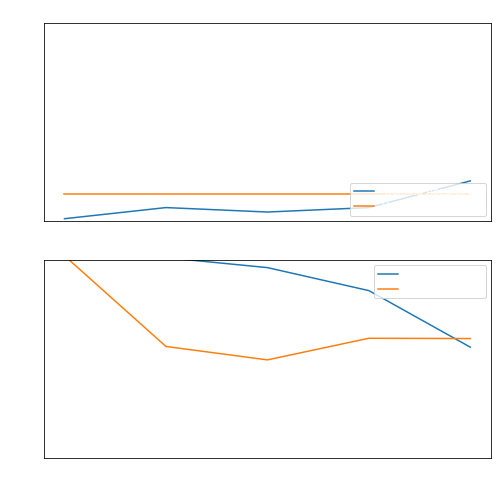

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

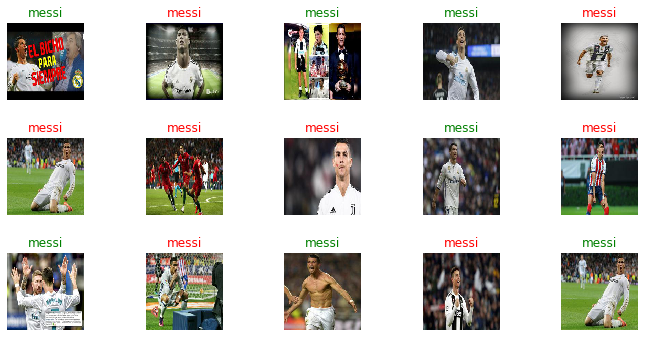

In [73]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()

plot_images(image_batch, labels_batch, predicted_class_names)

##Application base model

In [74]:
base_model = ResNet50V2(input_shape=IMAGE_SIZE+(3,),
                                               include_top=False,
                                               weights='imagenet')

94674944/94668760 [==============================] - 3s 0us/step


In [0]:
base_model.trainable = False

In [76]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [77]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')    
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [79]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 1 steps
Epoch 1/5
5/5 [==============================] - 26s 5s/step - loss: 1.6029 - accuracy: 0.3896 - val_loss: 1.6229 - val_accuracy: 0.5000
Epoch 2/5
5/5 [==============================] - 22s 4s/step - loss: 0.8978 - accuracy: 0.5779 - val_loss: 0.7572 - val_accuracy: 0.5000
Epoch 3/5
5/5 [==============================] - 23s 5s/step - loss: 0.7140 - accuracy: 0.5455 - val_loss: 0.9375 - val_accuracy: 0.5000
Epoch 4/5
5/5 [==============================] - 23s 5s/step - loss: 0.6418 - accuracy: 0.6104 - val_loss: 0.7383 - val_accuracy: 0.5000
Epoch 5/5
5/5 [==============================] - 22s 4s/step - loss: 0.5762 - accuracy: 0.7208 - val_loss: 0.7614 - val_accuracy: 0.5000


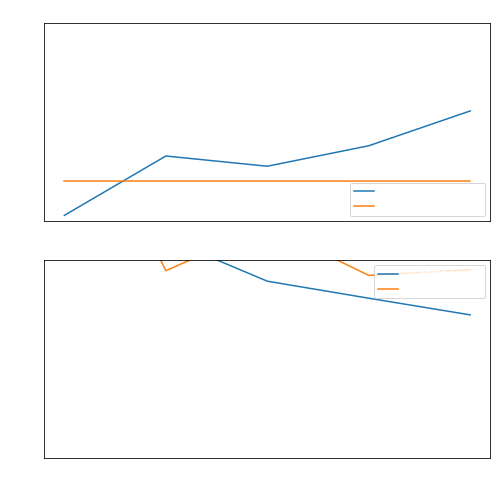

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

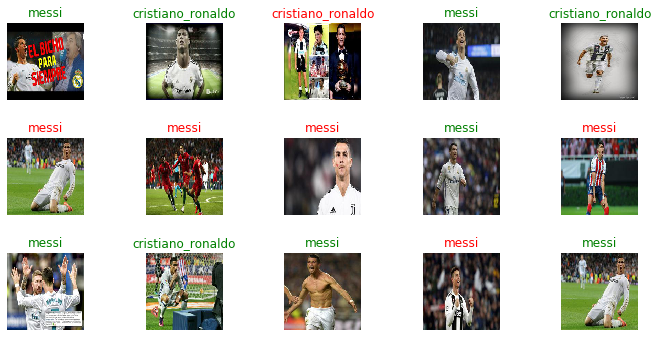

In [82]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Fine tuning

In [0]:
base_model.trainable = True

In [84]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 160
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  190


In [85]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 16,542,721
Non-trainable params: 9,121,280
_________________________________________________________________


In [86]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=5,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_data_gen)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 1 steps
Epoch 5/10
5/5 [==============================] - 38s 8s/step - loss: 1.0909 - accuracy: 0.4156 - val_loss: 1.0906 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 34s 7s/step - loss: 0.7467 - accuracy: 0.4351 - val_loss: 2.7033 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 33s 7s/step - loss: 0.6976 - accuracy: 0.4935 - val_loss: 4.9796 - val_accuracy: 0.5000
Epoch 8/10
5/5 [==============================] - 34s 7s/step - loss: 0.6833 - accuracy: 0.5455 - val_loss: 8.5152 - val_accuracy: 0.5000
Epoch 9/10
5/5 [==============================] - 34s 7s/step - loss: 0.6717 - accuracy: 0.5844 - val_loss: 14.4992 - val_accuracy: 0.5000
Epoch 10/10
5/5 [==============================] - 33s 7s/step - loss: 0.6497 - accuracy: 0.6104 - val_loss: 22.9027 - val_accuracy: 0.5000


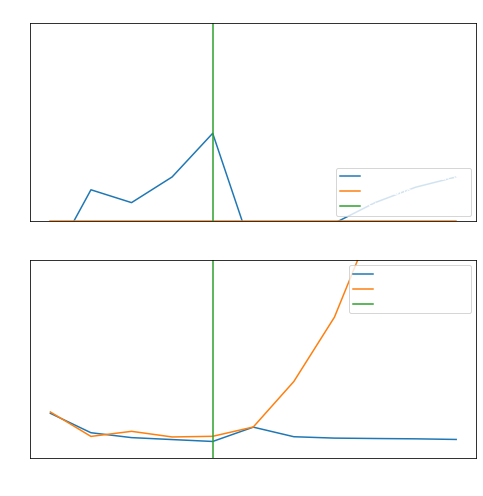

In [87]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 7.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

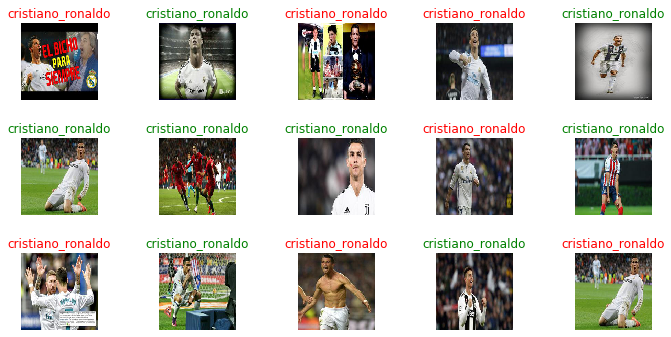

In [88]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)